In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import dblquad
import scipy

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old


Welcome to JupyROOT 6.12/04


# Muon-weighted average

## Import the common data files

In [2]:
# Import sample file
time_avg_df = pd.read_hdf('mu_avg/sample_time_avg.h5', key='60hr')

# import the muon dist files
mu_hist = np.loadtxt('mu_avg/60beam_preliminary.csv').transpose()

# use Eva's fitting
xdata = np.sum(mu_hist,0)/np.max(np.sum(mu_hist,0))  # note that the axes are reversed from Eva's
ydata = np.sum(mu_hist,1)/np.max(np.sum(mu_hist,1))  # because of the transpose above

xbins = np.linspace(-199.75, 199.75, 800)
ybins = np.linspace(-199.75, 199.75, 800)


## Define the muon distribution

The muon distribution is modeled as a guassian in the y-dimension times a sum of three gaussians in the x-dimension.

In [3]:
def Gaussian(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def x_fit(x, m1, m2, m3, s1, s2, s3, A1, A2, A3):
    return Gaussian(x, m1, s1, A1) + Gaussian(x, m2, s2, A2) + Gaussian(x, m3, s3, A3)


In [4]:
## The y gaussian fit is straight forward

Yresults, _ = curve_fit(Gaussian, ybins, ydata)

The x gaussian fit requires "training" on the data set. Because it has nine independent parameters, we want to reduce that value to four parameters (corresponding roughly to amplitude, position, width, and skew). We fit all 9 parameters, then define 5 relationships bewtween them. This leaves us with 4 independent parameters.

In [5]:
Xparams, _ = curve_fit(x_fit, xbins, xdata, p0=[-24, -2, 20, 8.3, 12.7, 9.9, 0.17, 0.5, 0.9])

sort_params = np.argsort(Xparams[6:9])

## variables: A1, m1 (highest peak), s1, (A1-A3)/A1=d
a2 = Xparams[sort_params[1]+6]/Xparams[sort_params[2]+6]
s2 = Xparams[sort_params[1]+3]/Xparams[sort_params[0]+3]
s3 = Xparams[sort_params[2]+3]/Xparams[sort_params[0]+3]
d2 = Xparams[sort_params[0]] - Xparams[sort_params[1]]
d3 = Xparams[sort_params[0]] - Xparams[sort_params[2]]

def SumGaussian(x, mu, sigma, A, d):
    return Gaussian(x, mu, sigma, A) + Gaussian(x, mu-d2, s2*sigma, (1-d)*A*a2) + Gaussian(x, mu-d3, s3*sigma, A*(1-d))

Xresults = [Xparams[sort_params[0]], Xparams[sort_params[0]+3], Xparams[sort_params[0]+6],
            (Xparams[sort_params[0]+6]-Xparams[sort_params[2]+6])/Xparams[sort_params[0]+6]]

The muon distribution is the product of the x and y distributions. Because this is used as a weighting function, the amplitude doesn't matter, so it is set to 1 for both 1D distributions.

In [6]:
def mu_dist(y, x, mu_x, sigma_x, d_x, mu_y, sigma_y):  # in mm!!!!!!!!!!!

    rho = Gaussian(y, mu_y, sigma_y, 1)
    rho *= SumGaussian(x, mu_x, sigma_x, 1, d_x)

    return rho


N(x, mu, sigma) = exp(-1/2 * (x-mu)^2/sigma^2)

-----X profiles-----

Fit equation: f(x) = A*N(x, m, s) + A*(1-d)*a2*N(x, m-d2, s*s2) + A*(1-d)*N(x, m-d3, s*s3)

with a2= 0.5631303186634135 , d2= -21.978445189836872 , d3= -44.630442580736144 , s2= 1.6846673885039152 , s3= 1.233366311863845

Station 12
m:  -24.38433499839929 
s:  7.912635875525332 
d:  -4.2886411499353


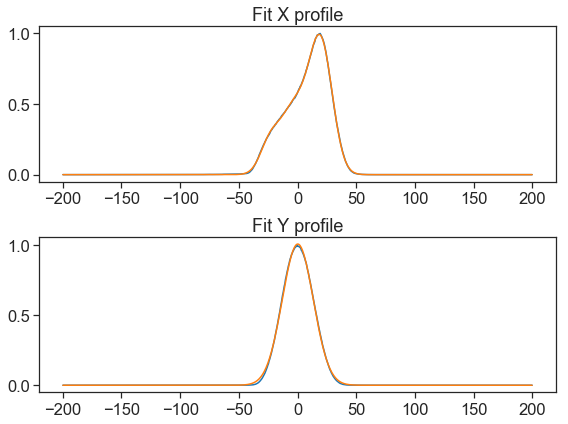

In [7]:
print "\nN(x, mu, sigma) = exp(-1/2 * (x-mu)^2/sigma^2)"
print "\n-----X profiles-----"
print "\nFit equation: f(x) = A*N(x, m, s) + A*(1-d)*a2*N(x, m-d2, s*s2) + A*(1-d)*N(x, m-d3, s*s3)"
print "\nwith a2=", a2, ", d2=", d2, ", d3=", d3, ", s2=", s2, ", s3=", s3
print "\nStation 12\nm: ", Xresults[0], "\ns: ", Xresults[1], "\nd: ", Xresults[3]

fig, axs = plt.subplots(2,1)

#x profile
axs[0].plot(xbins, xdata)
axs[0].plot(xbins, SumGaussian(xbins, Xresults[0], Xresults[1], Xresults[2], Xresults[3]))
axs[0].set_title("Fit X profile")

#y profile
axs[1].plot(ybins, ydata)
axs[1].plot(ybins, Gaussian(ybins, Yresults[0], Yresults[1], Yresults[2]))
axs[1].set_title("Fit Y profile")

fig.set_size_inches(8,6)
fig.tight_layout()


## Perform the 2D integral

The integrand is the product of the muon distribution and the field map in a given station. Note that there is also a (711.2 + x) factor to account for the circular path. The normalization integrand is the muon distribution times the circular factor. **NOTE: The muon distribution is currently in mm, while the field map is in cm. This should be changed to avoid problems in the future.**

The average field from each station is then weighted by the station's azimuthal extent and averaged over the full ring.

In [14]:
station_centers = (trfp.STATION_BARCODE_EDGES[1:] + trfp.STATION_BARCODE_EDGES[:-1])/2
station_centers[2] += 180

weights = (trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1])%360

def field_map(y, x, st):  # in cm
    _st = 'st'+str(st)+','

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    B = time_avg_df[_st+'m1']
    B += time_avg_df[_st+'m2'] * (r/4.5) * np.cos(theta)
    B += time_avg_df[_st+'m3'] * (r/4.5) * np.sin(theta)
    B += time_avg_df[_st+'m5'] * (r/4.5)**2 * np.cos(2*theta)
    B += time_avg_df[_st+'m4'] * (r/4.5)**2 * np.sin(2*theta)
    B += time_avg_df[_st+'m6'] * (r/4.5)**3 * np.sin(3*theta)

    return B

# Note the 10* in mu_dist, converting cm to mm

def integrand(y, x, st, mu_x, sigma_x, d_x, mu_y, sigma_y):
    return (711.2 + x) * mu_dist(10*y, 10*x, mu_x, sigma_x, d_x, mu_y, sigma_y) * field_map(y, x, st)

def normalization(y, x, mu_x, sigma_x, d_x, mu_y, sigma_y):
    return (711.2 + x) * mu_dist(10*y, 10*x, mu_x, sigma_x, d_x, mu_y, sigma_y)

field_avg = 0

for st in range(72):
    
    print '\rStation ' + str(st),

    B_int, _ = dblquad(integrand, -10, 10, lambda x: -10, lambda x: 10,
                       args=[st, Xresults[0], Xresults[1], Xresults[3], Yresults[0], Yresults[1]],
                       epsabs=0.1, epsrel=0.1)
    B_norm, _ = dblquad(normalization, -10, 10, lambda x: -10, lambda x: 10,
                        args=[Xresults[0], Xresults[1], Xresults[3], Yresults[0], Yresults[1]],
                        epsabs=0.1, epsrel=0.1)
    B_weight = B_int/B_norm

    field_avg += B_weight * weights[st]/360
    
print '\n'
print field_avg
print field_avg/61.79

field_avg_no_co = field_avg

Station 71                                                                     

51758.14662160731
837.6460045574901


## 1+1+2D model

We can test that, given an azimuthally-invariant beam, the result from above equals the result when the full ring's field map is averaged first, then weight by the muon distribution.

In [15]:
# naive average

B = np.zeros(6)
for m in range(6):
    for st in range(72):
        stm = 'st'+str(st)+',m'+str(m+1)
        B[m] += time_avg_df[stm] * weights[st] / 360

def field_map(y, x, st):  # in cm
#     _st = 'st'+str(st)+','

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    out = B[0]
    out += B[1] * (r/4.5) * np.cos(theta)
    out += B[2] * (r/4.5) * np.sin(theta)
    out += B[4] * (r/4.5)**2 * np.cos(2*theta)
    out += B[3] * (r/4.5)**2 * np.sin(2*theta)
    out += B[5] * (r/4.5)**3 * np.sin(3*theta)

    return out

def integrand(y, x, st, mu_x, sigma_x, d_x, mu_y, sigma_y):
    return (711.2 + x) * mu_dist(10*y, 10*x, mu_x, sigma_x, d_x, mu_y, sigma_y) * field_map(y, x, st)

def normalization(y, x, mu_x, sigma_x, d_x, mu_y, sigma_y):
    return (711.2 + x) * mu_dist(10*y, 10*x, mu_x, sigma_x, d_x, mu_y, sigma_y)

B_int, _ = dblquad(integrand, -10, 10, lambda x: -10, lambda x: 10,
                   args=[st, Xresults[0], Xresults[1], Xresults[3], Yresults[0], Yresults[1]],
                   epsabs=0.1, epsrel=0.1)
B_norm, _ = dblquad(normalization, -10, 10, lambda x: -10, lambda x: 10,
                    args=[Xresults[0], Xresults[1], Xresults[3], Yresults[0], Yresults[1]],
                    epsabs=0.1, epsrel=0.1)
B_weight = B_int/B_norm

print B_weight
print B_weight/61.79

51758.1466216
837.646004557


The following are the differences between the 1+3D method and the 1+1+2D method.

In [16]:
print field_avg - B_weight
print (field_avg - B_weight)/61.79

2.1827872842550278e-11
3.5325898757970996e-13


## Closed Orbit correction

In [17]:
## Using Simon's proposed functions for the horizontal and vertical closed orbits

def co_v(phi):
    n = 0.18
    Ds     = np.array([11.8,  4.8,  3.7,  0.5,   4.3, 6.0])  # ppm
    phases = np.array([8.7, -87.7, 51.5, 88.5, -54.6, -23.8])/180.*np.pi
    Ns = np.arange(1,Ds.shape[0]+1)
    
    return 7111./1e6 * (Ds/((1.-n)-Ns**2) * np.cos(Ns*phi + phases)).sum()

def co_h(phi):
    n = 0.18
    Ds     = np.array([31.6,  45.5,  19.2,  39.7,   16.6, 31.0])  # ppm
    phases = np.array([-33.5, 64.2, 80.2, 70.7, -50.2, 84.8])/180.*np.pi
    Ns = np.arange(1,Ds.shape[0]+1)
    
    return 7111./1e6 * (Ds/((n)-Ns**2) * np.cos(Ns*phi + phases)).sum()

In [18]:
station_centers = (trfp.STATION_BARCODE_EDGES[1:] + trfp.STATION_BARCODE_EDGES[:-1])/2
station_centers[2] += 180

weights = (trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1])%360

def field_map(y, x, st):  # in cm
    _st = 'st'+str(st)+','

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    B = time_avg_df[_st+'m1']
    B += time_avg_df[_st+'m2'] * (r/4.5) * np.cos(theta)
    B += time_avg_df[_st+'m3'] * (r/4.5) * np.sin(theta)
    B += time_avg_df[_st+'m5'] * (r/4.5)**2 * np.cos(2*theta)
    B += time_avg_df[_st+'m4'] * (r/4.5)**2 * np.sin(2*theta)
    B += time_avg_df[_st+'m6'] * (r/4.5)**3 * np.sin(3*theta)

    return B

def _mu_x(st):
    return co_h(station_centers[st])

def _mu_y(st):
    return co_v(station_centers[st])

# Note the 10* in mu_dist, converting cm to mm

def integrand(y, x, st, mu_x, sigma_x, d_x, mu_y, sigma_y):
    return (711.2 + x) * mu_dist(10*y, 10*x, mu_x, sigma_x, d_x, mu_y, sigma_y) * field_map(y, x, st)

def normalization(y, x, mu_x, sigma_x, d_x, mu_y, sigma_y):
    return (711.2 + x) * mu_dist(10*y, 10*x, mu_x, sigma_x, d_x, mu_y, sigma_y)

field_avg = 0

for st in range(72):
    
    print '\rStation ' + str(st),

    B_int, _ = dblquad(integrand, -10, 10, lambda x: -10, lambda x: 10,
                       args=[st, Xresults[0]+_mu_x(st), Xresults[1], Xresults[3], Yresults[0]+_mu_y(st), Yresults[1]],
                       epsabs=0.1, epsrel=0.1)
    B_norm, _ = dblquad(normalization, -10, 10, lambda x: -10, lambda x: 10,
                        args=[Xresults[0]+_mu_x(st), Xresults[1], Xresults[3], Yresults[0]+_mu_y(st), Yresults[1]],
                        epsabs=0.1, epsrel=0.1)
    B_weight = B_int/B_norm

    field_avg += B_weight * weights[st]/360

print '\n'
print field_avg
print field_avg/61.79

field_avg_co = field_avg

Station 71                                                                       

51757.6704526406
837.6382983110633


The numbers below are the difference in the average field between including the closed orbit and assuming no closed orbit.

In [19]:
## difference including the closed orbit
print field_avg_co - field_avg_no_co
print (field_avg_co - field_avg_no_co)/61.79

-0.47616896670660935
-0.007706246426713212
